# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Получите данные из файла [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).


- Создайте фрейм данных `df` со столбцами: `date`, `am`, `pm`, `target`, где `date` - дата дня, `am` - количество коммитов в течение дня до полудня (целое число), `pm` - количество коммитов в течение дня после полудня (целое число), `target` - выходные/рабочие_дни.

In [2]:
# Загрузка данных из файла
file_path = '../data/checker_timestamp.csv'
df = pd.read_csv(file_path, header=None, names=['timestamp'], skiprows=1)

# Преобразование временной метки в формат datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [3]:
# Извлечение даты, am, pm и целевого столбца
df['date'] = df['timestamp'].dt.date
df['am'] = df['timestamp'].dt.hour < 12
df['pm'] = df['timestamp'].dt.hour >= 12
df['target'] = df['timestamp'].dt.weekday < 5  # 0-4 — рабочие дни, 5-6 — выходные

# Агрегация данных
# группируем данные по столбцу date, агрегируем данные, суммируя значения в столбцах am и pm для каждого дня. 
# Для столбца target мы берем максимальное значение, чтобы определить, был ли день рабочим или выходным.
df_agg = df.groupby('date').agg(
    am=pd.NamedAgg(column='am', aggfunc='sum'),
    pm=pd.NamedAgg(column='pm', aggfunc='sum'),
    target=pd.NamedAgg(column='target', aggfunc='max')
).reset_index()

# Преобразование целевого столбца в формат weekend/working_day
df_agg['target'] = df_agg['target'].apply(lambda x: 'working_day' if x else 'weekend')

# Сохранение DataFrame в файл
df_agg.to_csv('../data/am_pm.csv', index=False)

## 2. Exploratory analysis

- Создайте график, где x - это am, y - это pm, каждая точка - это день, рабочие дни и выходные должны иметь разные цвета.


- Как вы думаете, глядя на график, будет ли легко классифицировать дни, имеющие эти две характеристики? Введите свой ответ в ячейку markdown в конце этого раздела: «да, это легко» или «нет, это не легко».

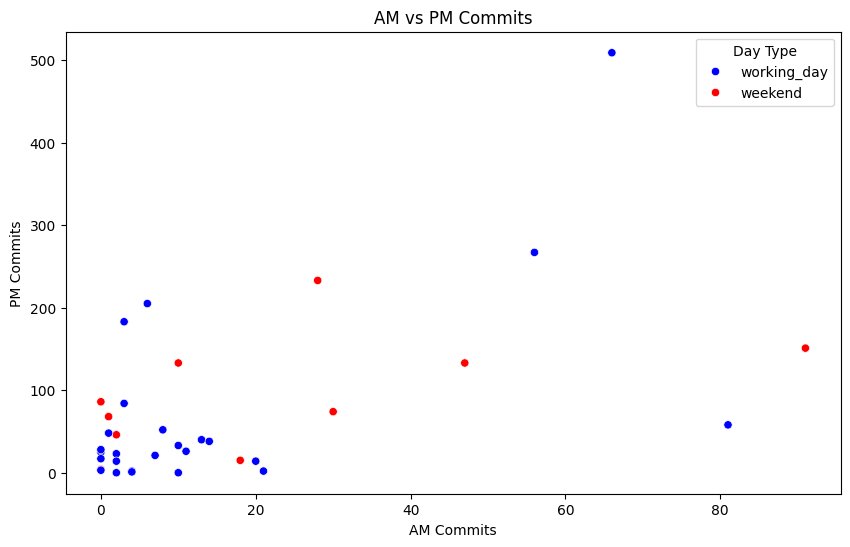

In [4]:
# График
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg, x='am', y='pm', hue='target', palette=['blue', 'red'])
plt.title('AM vs PM Commits')
plt.xlabel('AM Commits')
plt.ylabel('PM Commits')
plt.legend(title='Day Type')
plt.show()

Ответ: Нет, не легко

## 3. Logistic regression

- Обучите логистическую регрессию на своих данных, используя `am` и `pm`, параметры: `random state=21`, `fit_intercept=False`.


- Сделайте прогнозы для каждого дня вашего набора данных и добавьте их в ваш dataframe с именем столбца `predict`.


- Сохраните dataframe в файле в подпапке day `data` с именем `am_pm.csv`.


- Нарисуйте еще один график, как вы делали раньше, но цвет должен быть взят из `predict`.

- Глядя на график, как вы думаете, были ли сделаны хорошие прогнозы? Введите свой ответ в ячейку markdown в конце этого раздела: «да, это хорошо»; «нет, это не хорошо».

In [5]:
X = df_agg[['am', 'pm']]
y = df_agg['target'].apply(lambda x: 1 if x == 'working_day' else 0)

# Обучение модели
model = LogisticRegression(random_state=21, fit_intercept=False)
model.fit(X, y)

LogisticRegression(fit_intercept=False, random_state=21)

In [6]:
# Прогноз
df_agg['predict'] = model.predict(X)
df_agg['predict'] = df_agg['predict'].apply(lambda x: 'working_day' if x == 1 else 'weekend')

In [7]:
df_agg.to_csv('../data/am_pm.csv', index=False)

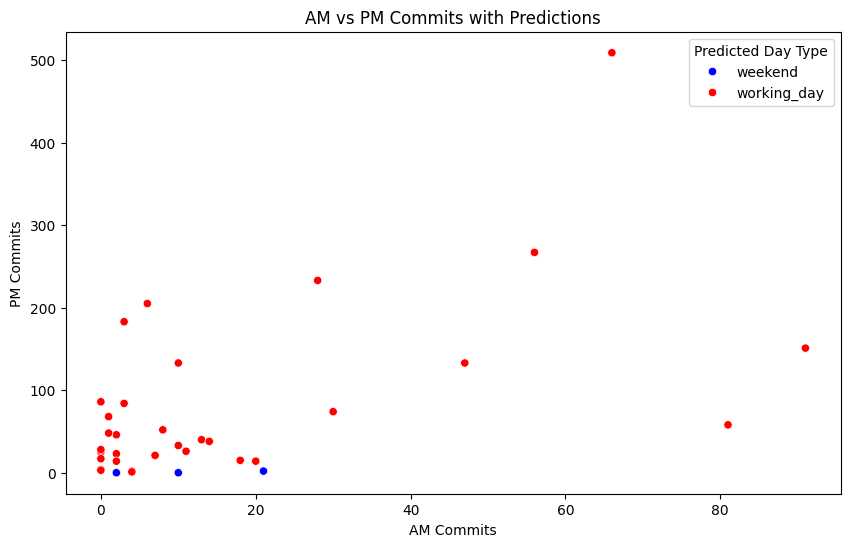

In [8]:
# График
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg, x='am', y='pm', hue='predict', palette=['blue', 'red'])
plt.title('AM vs PM Commits with Predictions')
plt.xlabel('AM Commits')
plt.ylabel('PM Commits')
plt.legend(title='Predicted Day Type')
plt.show()

Ответ: Нет, не хорошо

## 4. Evaluation

- Рассчитайте точность для ваших прогнозов.


- Рассчитайте точность для наивного случая, когда каждый из ваших прогнозов является значением вашего самого популярного класса дня.


- Сравнивая точность, считаете ли вы, что классификатор сделал хорошие прогнозы? Запишите свой ответ в ячейку markdown в конце раздела: «да, это хорошо»; «нет, это не хорошо».

In [9]:
# Расчет точности
accuracy = accuracy_score(y, df_agg['predict'].apply(lambda x: 1 if x == 'working_day' else 0))


In [10]:
# Naive baseline accuracy
naive_prediction = df_agg['target'].value_counts().idxmax()
naive_accuracy = (df_agg['target'] == naive_prediction).mean()

print(f'Model Accuracy: {accuracy}')
print(f'Naive Baseline Accuracy: {naive_accuracy}')

Model Accuracy: 0.6285714285714286
Naive Baseline Accuracy: 0.7142857142857143


Ответ: Нет, не хорошо

In [11]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     35 non-null     object
 1   am       35 non-null     int64 
 2   pm       35 non-null     int64 
 3   target   35 non-null     object
 4   predict  35 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.5+ KB
